In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [50]:
n_epochs = 1
batch_size_train = 8
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [51]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [52]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [53]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [54]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [55]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [56]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [57]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-52-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3316, Accuracy: 1137/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.456411
Train Epoch: 1 [80/60000 (0%)]	Loss: 2.351252
Train Epoch: 1 [160/60000 (0%)]	Loss: 2.236461
Train Epoch: 1 [240/60000 (0%)]	Loss: 2.316591
Train Epoch: 1 [320/60000 (1%)]	Loss: 2.325806
Train Epoch: 1 [400/60000 (1%)]	Loss: 2.041658
Train Epoch: 1 [480/60000 (1%)]	Loss: 2.149686
Train Epoch: 1 [560/60000 (1%)]	Loss: 2.018636
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.277481
Train Epoch: 1 [720/60000 (1%)]	Loss: 2.157194
Train Epoch: 1 [800/60000 (1%)]	Loss: 1.880101
Train Epoch: 1 [880/60000 (1%)]	Loss: 1.759060
Train Epoch: 1 [960/60000 (2%)]	Loss: 1.339046
Train Epoch: 1 [1040/60000 (2%)]	Loss: 1.739488
Train Epoch: 1 [1120/60000 (2%)]	Loss: 1.679668
Train Epoch: 1 [1200/60000 (2%)]	Loss: 1.464593
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.709363
Train Epoch: 1 [1360/60000 (2%)]	Loss: 1.674632
Train Epoch: 1 [1440/60000 (2%)]	Loss: 1.986495
Train Epoch: 1 [1520/60000 (3%)]	Loss: 1.30250

Train Epoch: 1 [13600/60000 (23%)]	Loss: 0.301211
Train Epoch: 1 [13680/60000 (23%)]	Loss: 0.069472
Train Epoch: 1 [13760/60000 (23%)]	Loss: 0.607229
Train Epoch: 1 [13840/60000 (23%)]	Loss: 0.637934
Train Epoch: 1 [13920/60000 (23%)]	Loss: 0.110397
Train Epoch: 1 [14000/60000 (23%)]	Loss: 0.561282
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.431201
Train Epoch: 1 [14160/60000 (24%)]	Loss: 0.086004
Train Epoch: 1 [14240/60000 (24%)]	Loss: 0.742583
Train Epoch: 1 [14320/60000 (24%)]	Loss: 0.247510
Train Epoch: 1 [14400/60000 (24%)]	Loss: 0.157842
Train Epoch: 1 [14480/60000 (24%)]	Loss: 0.396310
Train Epoch: 1 [14560/60000 (24%)]	Loss: 0.576951
Train Epoch: 1 [14640/60000 (24%)]	Loss: 0.350543
Train Epoch: 1 [14720/60000 (25%)]	Loss: 0.722545
Train Epoch: 1 [14800/60000 (25%)]	Loss: 0.163074
Train Epoch: 1 [14880/60000 (25%)]	Loss: 0.095111
Train Epoch: 1 [14960/60000 (25%)]	Loss: 0.244747
Train Epoch: 1 [15040/60000 (25%)]	Loss: 0.585696
Train Epoch: 1 [15120/60000 (25%)]	Loss: 0.528126


Train Epoch: 1 [26720/60000 (45%)]	Loss: 0.011949
Train Epoch: 1 [26800/60000 (45%)]	Loss: 0.088125
Train Epoch: 1 [26880/60000 (45%)]	Loss: 0.094216
Train Epoch: 1 [26960/60000 (45%)]	Loss: 0.081801
Train Epoch: 1 [27040/60000 (45%)]	Loss: 0.029186
Train Epoch: 1 [27120/60000 (45%)]	Loss: 0.051707
Train Epoch: 1 [27200/60000 (45%)]	Loss: 0.025292
Train Epoch: 1 [27280/60000 (45%)]	Loss: 0.467476
Train Epoch: 1 [27360/60000 (46%)]	Loss: 0.642575
Train Epoch: 1 [27440/60000 (46%)]	Loss: 0.832945
Train Epoch: 1 [27520/60000 (46%)]	Loss: 1.005524
Train Epoch: 1 [27600/60000 (46%)]	Loss: 0.197183
Train Epoch: 1 [27680/60000 (46%)]	Loss: 0.434511
Train Epoch: 1 [27760/60000 (46%)]	Loss: 0.839246
Train Epoch: 1 [27840/60000 (46%)]	Loss: 0.220828
Train Epoch: 1 [27920/60000 (47%)]	Loss: 0.084322
Train Epoch: 1 [28000/60000 (47%)]	Loss: 0.160551
Train Epoch: 1 [28080/60000 (47%)]	Loss: 0.034731
Train Epoch: 1 [28160/60000 (47%)]	Loss: 0.428008
Train Epoch: 1 [28240/60000 (47%)]	Loss: 0.244964


Train Epoch: 1 [39840/60000 (66%)]	Loss: 0.141793
Train Epoch: 1 [39920/60000 (67%)]	Loss: 0.414772
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.144796
Train Epoch: 1 [40080/60000 (67%)]	Loss: 0.560146
Train Epoch: 1 [40160/60000 (67%)]	Loss: 0.297977
Train Epoch: 1 [40240/60000 (67%)]	Loss: 0.070268
Train Epoch: 1 [40320/60000 (67%)]	Loss: 0.075347
Train Epoch: 1 [40400/60000 (67%)]	Loss: 0.587118
Train Epoch: 1 [40480/60000 (67%)]	Loss: 0.010152
Train Epoch: 1 [40560/60000 (68%)]	Loss: 0.077430
Train Epoch: 1 [40640/60000 (68%)]	Loss: 0.452427
Train Epoch: 1 [40720/60000 (68%)]	Loss: 0.178620
Train Epoch: 1 [40800/60000 (68%)]	Loss: 0.498041
Train Epoch: 1 [40880/60000 (68%)]	Loss: 0.114095
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.365719
Train Epoch: 1 [41040/60000 (68%)]	Loss: 0.331808
Train Epoch: 1 [41120/60000 (69%)]	Loss: 1.024023
Train Epoch: 1 [41200/60000 (69%)]	Loss: 0.264714
Train Epoch: 1 [41280/60000 (69%)]	Loss: 0.362342
Train Epoch: 1 [41360/60000 (69%)]	Loss: 0.038852


Train Epoch: 1 [53040/60000 (88%)]	Loss: 0.064086
Train Epoch: 1 [53120/60000 (89%)]	Loss: 0.412773
Train Epoch: 1 [53200/60000 (89%)]	Loss: 0.657553
Train Epoch: 1 [53280/60000 (89%)]	Loss: 0.001029
Train Epoch: 1 [53360/60000 (89%)]	Loss: 0.474677
Train Epoch: 1 [53440/60000 (89%)]	Loss: 0.242647
Train Epoch: 1 [53520/60000 (89%)]	Loss: 0.176473
Train Epoch: 1 [53600/60000 (89%)]	Loss: 0.031396
Train Epoch: 1 [53680/60000 (89%)]	Loss: 0.305897
Train Epoch: 1 [53760/60000 (90%)]	Loss: 0.053158
Train Epoch: 1 [53840/60000 (90%)]	Loss: 0.141356
Train Epoch: 1 [53920/60000 (90%)]	Loss: 0.168307
Train Epoch: 1 [54000/60000 (90%)]	Loss: 0.004964
Train Epoch: 1 [54080/60000 (90%)]	Loss: 0.383648
Train Epoch: 1 [54160/60000 (90%)]	Loss: 0.248131
Train Epoch: 1 [54240/60000 (90%)]	Loss: 0.089303
Train Epoch: 1 [54320/60000 (91%)]	Loss: 0.578559
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.170828
Train Epoch: 1 [54480/60000 (91%)]	Loss: 0.416725
Train Epoch: 1 [54560/60000 (91%)]	Loss: 0.003704


Text(0, 0.5, 'negative log likelihood loss')

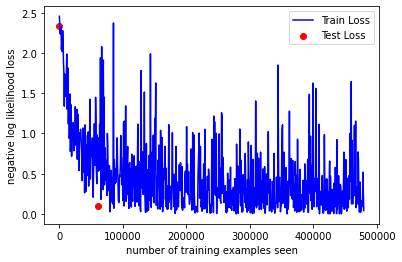

In [58]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [43]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
  output = network(example_data)

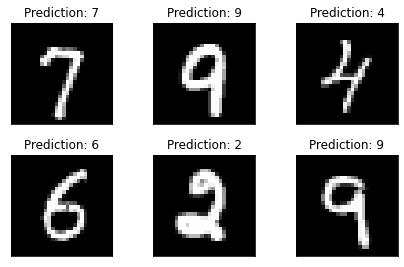

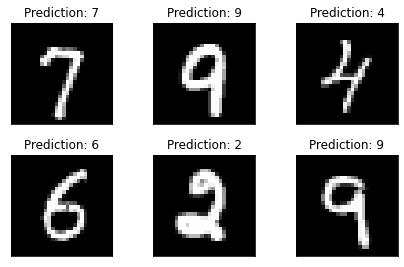

In [44]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [21]:
#continued_network = Net()
#continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
#network_state_dict = torch.load('./results/model.pth')
#network.load_state_dict(network_state_dict)

#optimizer_state_dict = torch.load('./results/optimizer.pth')
#continued_optimizer.load_state_dict(optimizer_state_dict)